# Predicting The Sale Price of a Home in Ames, Iowa

## Daniel Bernal, Raymond Vuong, Rohit Punjani, and Neal Davar 


## Introduction:

This dataset contains information on hundreds of homes, the various features these houses possess, and their SalePrice. These factors include but are not limited to LotShape, LandContour, Utilities, Neighborhood, and more. In our project, we are trying to understand how these features affect the ‘SalePrice’, which will serve as our label for this project. This can be useful to buyers of homes in Ames, Iowa as they might be able to understand what a home with certain specifications might cost them. Likewise, on the seller's side, based on a seller’s current home’s features, they might be able to make a more informed decision on whether they want to sell their house. Furthermore, though a lot of information on home price trends exists on platforms like Redfin, Realtor.com, and Zillow.com, it may be more difficult to quantify how certain features of a house, like the LandContour or Garage condition, directly affect the price of a home. For buyers and sellers who want or have custom modifications on their to-be property, respectively, quantifying the value of such modifications can be helpful. Though this data is only relevant to homes in Ames, Iowa, if more of this type of data was found across various cities across the US, it may help buyers and sellers nationwide.

In our project, we went through the standard steps of a machine learning project. We performed data cleaning, and feature engineering, modeled our data through various regression models since our sale price is a continuous variable, and then analyzed our results.



In [980]:
# import statements

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_regression


In [981]:
# Constants and other global variables: 

IL_F_ITERATIONS = 50

## Part 1: Data Cleaning

The first part of data cleaning was a modification of the dataset. Most of this data cleaning happens in the function in the function below clean_data. Because this dataset comes from a Kaggle competition, the test set does not have any labels. Per the TA’s advice, we split the original training dataset in half to make the training and testing dataset. From here, the first thing we did was drop the Id column. Next, we went through all the features and made sense of each one to understand what type of imputation would work best for each feature. We imputed all NaNs in numerical with 0’s except for the GarageYearBuilt. For this column, we imputed based on the average of that column since most of the years in the column were between 1900 - 2000’s, imputing with 0 in this column would skew the data. Thus, we decided to impute based on the average of this column. We imputed all categorical columns by substituting NaNs with “None.” Finally, we thought that the MSSubClass, originally a numerical feature, represents a class and thus should either be label encoded or converted to a column of strings and then one hot encoded. We chose the latter and converted the column’s type from int to string. Lastly, it may seem odd that we decided to impute these features individually. We tried selecting all numerical columns and imputing those based on the same rule but could not get it to work after spending a couple of hours on the issue.


Next, we searched for any duplicates in this dataset using the drop_duplicates function. 

Finally, to detect anomalies, we ran the Isolation Forest algorithm. In the parameters, we used a float value of less than 1 to prevent swamping and masking (prevented through subsampling under the hood). However, because we know this algorithm will randomly partition the decision space and cannot be used accurately if only run once. Therefore, we ran it 50 times. The threshold for a record to be labeled an “outlier” was if it appeared in more than 10% of the 50 runs. Then, these records were removed from the training dataset.

In [982]:
# clean data by dropping cols like Id, imputing value
# depending on the feature, and dropping duplicates:
def clean_data(dataset): 
    dataset.drop('Id', axis=1, inplace=True)
    null_counts = dataset.isnull().sum()
    missing_features = null_counts[null_counts > 0]
    print(missing_features)    
    
   
    # fillna on the basis of whether MasVnrArea, LotFrontage, or any other categorical feature with na values
    dataset['MSZoning'].fillna('None', inplace=True)
    dataset['LotFrontage'].fillna(0, inplace=True)
    dataset['Alley'].fillna('None', inplace=True)
    dataset['Utilities'].fillna('None', inplace=True)
    dataset['Exterior1st'].fillna('None', inplace=True)
    dataset['Exterior2nd'].fillna('None', inplace=True)
    dataset['MasVnrType'].fillna('None', inplace=True)
    dataset['MasVnrArea'].fillna(0, inplace=True)
    dataset['BsmtQual'].fillna('None', inplace=True)
    dataset['BsmtCond'].fillna('None', inplace=True)
    dataset['BsmtExposure'].fillna('None', inplace=True)
    dataset['BsmtFinType1'].fillna('None', inplace=True)
    dataset['BsmtFinSF1'].fillna(0, inplace=True)
    dataset['BsmtFinType2'].fillna('None', inplace=True)
    dataset['BsmtFinSF2'].fillna(0, inplace=True)
    dataset['BsmtUnfSF'].fillna(0, inplace=True)
    dataset['TotalBsmtSF'].fillna(0, inplace=True)
    dataset['BsmtFullBath'].fillna(0, inplace=True)
    dataset['BsmtHalfBath'].fillna(0, inplace=True)
    dataset['KitchenQual'].fillna('None', inplace=True)
    dataset['Functional'].fillna('None', inplace=True)
    dataset['FireplaceQu'].fillna('None', inplace=True)
    dataset['GarageType'].fillna('None', inplace=True)
    dataset['GarageYrBlt'].fillna(dataset['GarageYrBlt'].mean(), inplace=True)
    dataset['GarageFinish'].fillna('None', inplace=True)
    dataset['GarageCars'].fillna(0, inplace=True)
    dataset['GarageArea'].fillna(0, inplace=True)
    dataset['GarageQual'].fillna('None', inplace=True)
    dataset['GarageCond'].fillna('None', inplace=True)
    dataset['PoolQC'].fillna('None', inplace=True)
    dataset['Fence'].fillna('None', inplace=True)
    dataset['MiscFeature'].fillna('None', inplace=True)
    dataset['SaleType'].fillna('None', inplace=True)

    # drop duplicates:
    dataset.drop_duplicates(keep=False, inplace=True)

    # Changing categorial features to be stored as string
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)


    return dataset

## Part 2: Data Exploration 


The next four cells pertain to data exploration: 


Our data exploration starts in our main function, which we call the describe function to understand each feature's distribution better. Next, in the explore_data function, we made histograms for each numerical feature to observe the distributions visually. We were originally going to apply log transformations to the features with skewed distribution, especially skewed to the lower values on the x-axis. Examples of such features with skewed distributions include but are not limited to LotFrotnage, LotArea, BsmtFinSF2, and BsmtUnfSF. However, since we were going to normalize our data anyways, we decided against applying this transformation. Likewise, we made a heatmap to visualize the correlations between all numeric features. This also helped us in the feature engineering step below. Next, we did a chi-squared test to see if two categorical variables were independent of each other. We were looking for a relationship between the housing style and the neighborhood. The P-value measures the significance of the relationship between the two variables. We chose not to perform a 2-Z-test because it is similar to a Chi-squared test, but the Chi test is more robust with respect to the distribution of data. Finally, we performed a correlation between every feature and “SalePrice” to get a better idea of which features statistically have a greater effect on a home's final sale price. We did this to get a better idea of which features statistically have a greater effect on a home’s final sale price.

### Training Describe

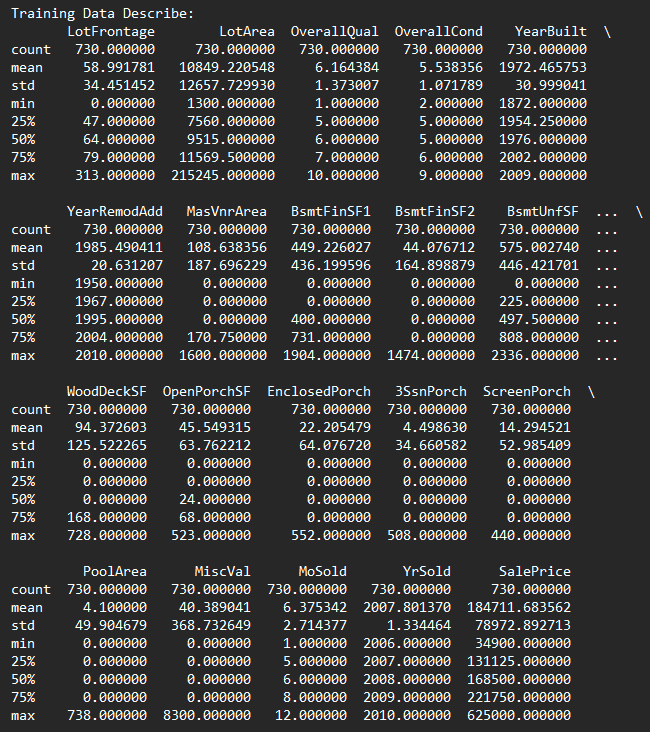


### Testing Describe

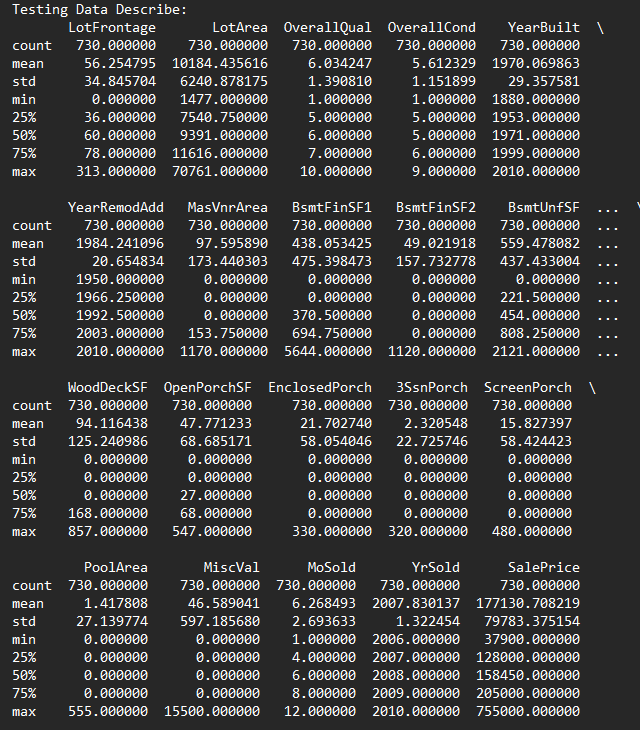


In [983]:
# on hot encode the data
def one_hot_encode(dataset):
    ohe_col_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']   

    dataset_dropped = pd.get_dummies(data=dataset, columns=ohe_col_list, drop_first=True)

    return dataset_dropped

In [984]:
# perform one square chi test: 
def one_square_chi(dataset): 
    contingency_table = pd.crosstab(
        dataset['HouseStyle'], dataset['Neighborhood'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print('Chi-squared statistic:', chi2)
    print('P-value:', p)
    print('Degrees of freedom:', dof)
    print('Expected values:', expected)


### Chi Squares Test Sample Run Screenshot

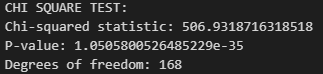


In [985]:
# perform correlation of every feature against the "SalePrice" label: 
def corr_salePrice(dataset): 
    X, y = dataset, dataset['SalePrice']
    # compute the F-value and p-value for each feature
    f_values, p_values = f_regression(X, y)

    # print the F-value and p-value for each feature
    # High F-value and low p-value = high significance b/w feature and 'sales price'
    for i, (f_val, p_val) in enumerate(zip(f_values, p_values)):
        print('Feature %d: F-value=%.2f, p-value=%.4f' % (i, f_val, p_val))


### Sample Corr Sales Price Function Run Output Screenshot
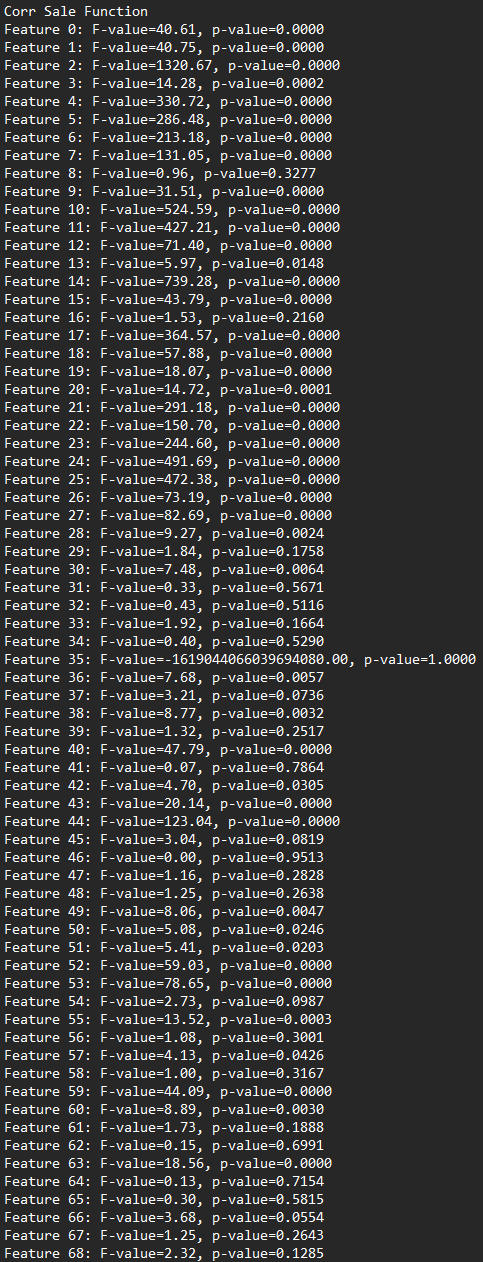

In [986]:
def explore_data(dataset):
    # grab all the numeric features and plot histograms
    numeric_feats = dataset.select_dtypes(
    include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    for i in numeric_feats.columns:
        plt.hist(numeric_feats[i])
        plt.title(i)
        plt.show()

    # plot correlation between features: 
    corr_mat = numeric_feats.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr_mat, square=True)
    plt.show()

### Sample Histograms Output Screenshot

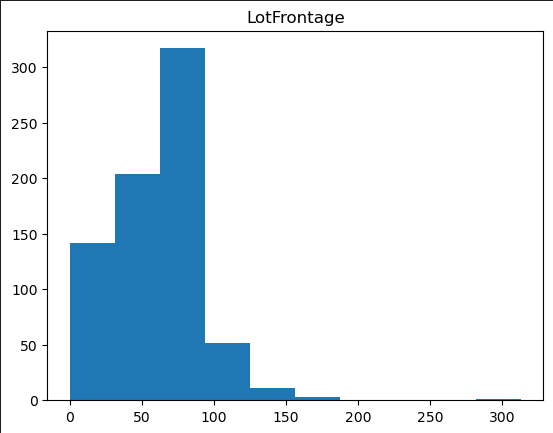
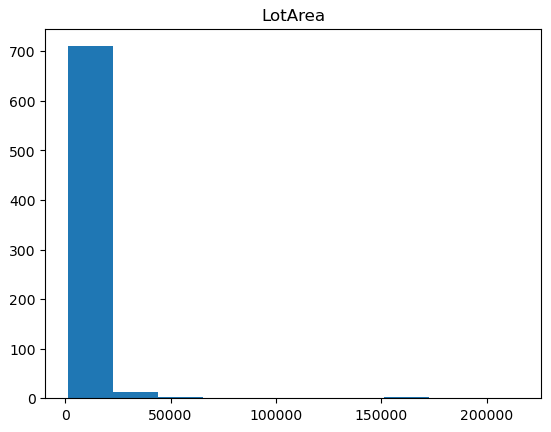
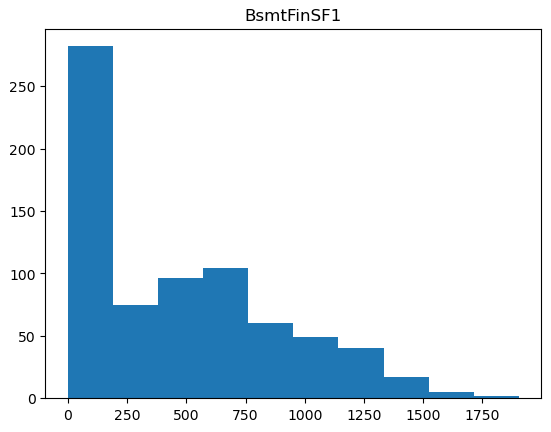
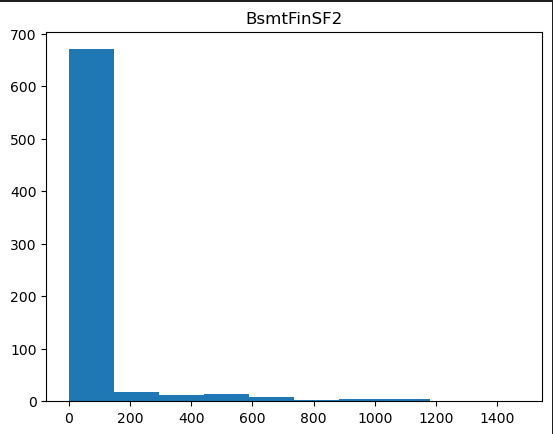


### Correlation Heatmap Screenshot

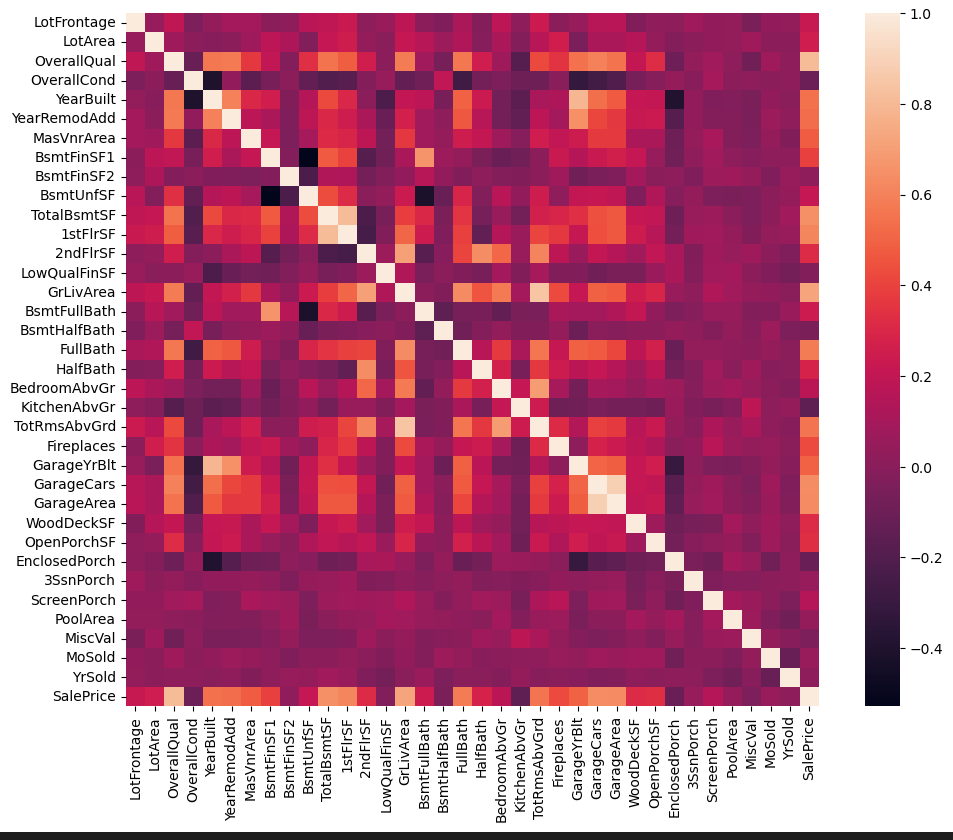


In [987]:
# Uses the isolation forest technique to find outliers across 50 iterations
# and removes records that are recorded as outliers > 10% of the time
def run_isolation_forest(training):
    # use isolation forests to find potential outliers:
    freq_outlier_map = {} 
    for i in range(0, IL_F_ITERATIONS):
        anomalies = IsolationForest().fit_predict(training, 0.5)
        training['anomalies'] = anomalies
        outlier_indices = training.loc[training['anomalies'] == -1].index
        # add outlier freqs to map
        for j in range(0, len(outlier_indices)):
            count = 0
            if outlier_indices[j] in freq_outlier_map: 
                count = freq_outlier_map[outlier_indices[j]]
            freq_outlier_map[outlier_indices[j]] = count + 1
        

        
    # drop outliers that are detected as anomalies more than 10% of the time
    final_outlier_indices = []
    print('Total # of Outliers: ')
    for outlier_index in freq_outlier_map.keys(): 
        if freq_outlier_map[outlier_index] > (0.10 * IL_F_ITERATIONS):
            final_outlier_indices.append(outlier_index)
    print(len(final_outlier_indices))
    print('Number of data points before outlier removal: ')
    print(len(training))
    training.drop(index=final_outlier_indices, inplace=True)
    print('Number of data points before after outlier removal: ')
    print(len(training))
    training.drop('anomalies', axis=1, inplace=True)


### Sample Isolation Forest Output Screenshot

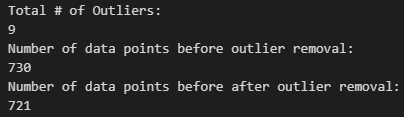

## Part 3: Feature Selection 

Much of our feature engineering was done through individual functions that performed either a single feature engineering modification to the dataset or performed multiple and evaluated the combined effect. However, before performing this feature engineering with specific functions, we one-hot encoded and normalized our data. We needed to one-hot encode our categorical variables to run the Isolation Forest Algorithm to detect outliers. Surprisingly, one hot encoding took longer than expected as we grappled with unexpected issues when working with SKLearn’s OneHotEncoder class. There are two main ways to one hot encode in industry. The first way is to use SKLearn’s OneHotEncoder, and the second is to use Pandas’ get_dummies function. Though both have similar features, SKLearn’s One Hot Encoder makes it significantly easier to fit the test dataset on the encoder built upon the training dataset. With parameters like “ignore_unknown” you can ignore unknown values for features in the testing dataset. Ultimately, we chose get_dummies because it was easier to work with. We set the drop_first parameter equal to true to avoid the dummy variable trap. Lastly, to replicate the ignore_unknown functionality found in SKLearn’s OneHotEncoder, we performed an inner join between the training and the testing datasets after encoding each individually with our one_hot_encode function. Then, we normalized our training and testing data using the normalize_data function as a prerequisite for Principal Component Analysis (PCA), used extensively in the pipelines we used to train and run our models.

The first feature engineering function we created was the fe_bathroom function. This function combines the total number of bathrooms in a given home. Previously the total number of bathrooms was split among full baths, half baths, basement full baths, and basement half baths. We combined all these bathrooms into a new column called TotalBathrooms and dropped the other columns.

The next feature engineering function we created was fe_porch. Like fe_bathrooms, this function aims to consolidate the square footage of porches across various columns into a single column. We combined the square footage from the OpenPorchSF, EnclosedPorch, 3SsnPorch, and ScreenPorch columns.

The penultimate feature engineering function we created was multi_collinear_removal. In this function, we removed one multicollinear feature from the two pairs of multicollinear pairs of features that we identified from the correlation heatmap in data exploration. Removing such multicollinear features can prevent the persistence of errors and the overinfluence of these features on models. The two pairs were (GarageArea, GarageCars) and (1stFlrSF, 2ndFlrSF). We dropped the GarageArea and 2ndFlrSF features.

The last feature engineering method we implemented was PCA through a Pipeline. 

If this were a larger dataset with information from other zip codes, another feature engineering method we might have implemented would be grouping neighborhoods by zip codes in Ames, Iowa. We decided not to do this because we will just assume normal market conditions and find patterns in house prices in certain neighborhoods. We won’t be able to find or account for macro trends like recessions without having more housing data beyond the state of Iowa.


In [988]:
# function that normalizes the training and testing data:
def normalize_data(train, test):
    # your code goes here
    train_norm = (train - train.min()) / (train.max() - train.min())
    test_norm = (test - test.min()) / (test.max() - test.min())
    return train_norm, test_norm

In [989]:
# feature engineering of consolidating bathroom
def fe_bathrooms(dataset):
    # consolidate bathroom columns into one col:
    dataset['TotalBathrooms'] = \
        dataset['FullBath'] + (0.5 * dataset['HalfBath']) + \
        dataset['BsmtFullBath'] + (0.5 * dataset['BsmtHalfBath'])
    res = dataset.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=False)
    return res

In [990]:
# feature engineering of consolidating porch sq ft: 
def fe_porch(dataset):
    # consolidate porch area into one column
    dataset['TotalPorchSF'] = dataset['OpenPorchSF'] + \
        dataset['EnclosedPorch'] + \
        dataset['3SsnPorch'] + dataset['ScreenPorch']

    res = dataset.drop(['OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', 'ScreenPorch'], axis=1, inplace=False)

    return res

In [991]:
# for multicollinar features, remove one of the two multicollinear features
def multi_collinear_removal(dataset): 
    # from the heat map GarageCars and GarageArea were multicollinear -> drop GarageArea
    # likewise 1stFlrSF and 2ndFlrSF were collinear -> drop 2ndFlrSF 
    res = dataset.drop(['GarageArea', '2ndFlrSF'], axis=1, inplace=False)
    return res


## Part 4: Model Creation and Rationale Behind Models 

For all of our models, we followed a similar process of using SciKit libraries and using a pipeline to run PCA first and then our model itself. One parameter that we had to tune for all of the models was the number of components since we’re using PCA. For gradient boosting, and decision tree regression we hypertuned max depth, minimum samples leaf, and max features since these models use decision trees. For KNN regression, we hypertuned the number of neighbors. And for adaboost, we hypertuned the number of estimators. Lastly, we were stumped on what to hypertune for linear regression so we only ended up doing cross-validation. However, we realized that the number of components for PCA are a hyperparameter so we then ran nested cross-validation. We used r2 as our scoring metric for the models’ performance on the training and testing set. The reason for this was because r2 reflects how well the model fits our data and also because it’s a lot more easier to intercept the results since it’s a value between 0 and 1. 

### Rationale Behind Decision Tree Regression
The decision tree regression model was one of the first models we chose since we learned a lot about them in class. Some of the pros we thought about were that decision trees are able to work on a wide range of data and features and with our long list of features it made sense. We also considered that decision trees are extremely good at handling outliers which we thought would be a great benefit if our isolation forest algorithm missed some outliers.

In [992]:
# Run Decision Tree Regression on our Data:
def do_decision_tree_regression(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    dtr = DecisionTreeRegressor()
    pipeline = Pipeline(
        steps=[('pca', pca), ('dt', dtr)])
    param_grid = {'pca__n_components': list(range(10,13)),
                  'dt__max_depth': [17,18,19,20], 'dt__min_samples_leaf': [
        10,11,12,13], 'dt__max_features': [8,9,10]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("DECISION TREE REGRESSION MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


### Rationale Behind Adaptive Boosting Regression

We found adaptive boosting regression while looking at the ensemble methods for SKLearn and were intrigued by it since it is an adaptive method that reassigns the weights for each instance. We read that AdaBoost regression uses decision trees in the training portion of the algorithm and decided this might be a good model for us to use since decision trees work well with our data. Aside from what we have said already, some of the pros we were taking into account when deciding on using this model were the high accuracy the model can achieve, its quick training time, and its automatic feature selection. Accuracy, as we have said in the other models, is extremely important to us since we are trying to predict the sale price of houses as accurately as we can. Automatic feature selection was something we thought was very interesting since it would automatically figure out which features were the most important for determining the sale price of a house. It’s also a plus that the algorithm doesn’t take that much time to run.


In [993]:
# run adaboost regression on training data
def do_adaBoost(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    ada = AdaBoostRegressor()
    pipeline = Pipeline(steps=[('pca', pca), ('ada', ada)])
    param_grid = {'pca__n_components': list(range(8,14)), 'ada__n_estimators': [10,11,12,13]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("ADA BOOST MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


### Rationale Behind KNN Regression

We chose to try KNN regression because it was extremely easy to implement and it requires no training which was something we were interested to see the results of. We wanted to see if the lack of training would give us a worse or better r2 score compared to our other models. Some things we had to consider with KNN regression was that it’s  not great with large data sets,  high dimensionality, missing data, or noise. We tried our best using isolation forests to deal with missing data and noise, and we also ran PCA with normalized data to deal with the dimensionality limits as well as the feature scaling requirement for KNN regression. 


In [994]:
# KNN Regression Model Implementation:
#KNN regression
def do_KNN_regression(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    knn = KNeighborsRegressor()
    pipeline = Pipeline(steps=[('pca', pca), ('knn', knn)])
    param_grid = {'pca__n_components': list(range(9,14)), 'knn__n_neighbors': [
        10,20,30,40]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("KNN REGRESSION MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)



### Rationale Behind Gradient Boosting Regression

We chose to try gradient boosting regression because it is known to be powerful at finding complex non-linear relationships between the target and the features. Gradient boosting regression is also extremely good at dealing with missing values, any outliers or noise we may have missed when doing isolation forests, and it also has good scalability to deal with large datasets and many features. Although one thing about gradient boosting regression is that it takes a really long time to run. However, it made sense for us to use gradient boosting since our data set is pretty large with a lot of features, as well as the fact that isolation forests were the only method we were using to remove outliers which we believe could miss outliers from time to time depending on the random seed we get. Finally, the relationship between some of our features and the sale price did not have an apparent relationship in our human eyes but since gradient boosting regression is good at finding complex non-linear relationships it made perfect sense to us to try it.

In [996]:
# run gradient boosting regression on dataset
def do_gradient_boosting_regression(training, testing):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis = 1, inplace=False)
  testing_labels = testing['SalePrice']
  testing_features = testing.drop('SalePrice', axis = 1, inplace=False)
  gbr = GradientBoostingRegressor()
  pca = PCA()
  pipeline = Pipeline(steps=[('pca', pca), ('gbr', gbr)])

  #innerloop of crossval
  param_grid = {'pca__n_components': list(range(10,15)), 'gbr__max_depth': [2,4,6,8], 'gbr__min_samples_leaf': [2,3,5,7], 'gbr__max_features': [3,5,7,9]}
  grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
  grid.fit(features, labels)
  print("GRADIENT BOOSTING MODEL: ")
  print("Best parameters: ", grid.best_params_)
  cv = cross_val_score(grid, features, labels, cv = 5)
  r2 = sum(cv)/cv.size
# TODO: Uncomment this:
#   Scores[0,2] = r2
  print("R2 with cross val", r2)
  test_accuracy = grid.score(testing_features, testing_labels)
  print("Accuracy after running model on test set: ", test_accuracy)


### Rationale Behind Linear Regression 

Linear regression was the first model we chose due to its simplicity and ability to handle large data sets with many features. We knew linear regression was probably not the best model for us since it typically assumes that there is a linear relationship between the features and sale price. Therefore, it would be hard to piece together nonlinear relationships between the features and the sale price. However, we decided to still try this model to give us a benchmark for the other models. 


In [997]:
# run a linear regression model
def do_LinReg(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    labels.values.ravel()
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    print(features.shape)
    print(labels.shape)
    print(features.head())
    print(labels.head())
    param_grid = {
        'pca__n_components': [9,13,15,20,24]
    }
    pca = PCA()
    linReg = LinearRegression() 
    pipeline = Pipeline(steps=[('pca', pca), ('linreg', linReg)])
    grid = GridSearchCV(pipeline, param_grid, cv=5)
    grid.fit(features, labels)
    print("LINEAR REGRESSION MODEL: ")
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


## Part 5: Methodology Behind Running Models

After creating our models we started by running each model individually three times without feature engineering. After each iteration we would tune our hyperparameters to a smaller range that contained what were the best parameters in the previous iteration. For example for our parameter max_features on the ADA Boost regression model we started with a broad set of n_estimators:[10, 20, 30, 40, 50, 60] and through our three iterations for this model we tuned it down to:[10, 11, 12, 13]. So for every model we start with broad parameters and slowly tune them to a more specific range. It was at this point that we realized we were in a real time crunch since some models like our gradient boosting models took over an hour to run at sometimes. To help with this the four of each ran different models to help speed up the process and logging every run’s result in our excel sheet along with what parameters were used and the best parameters in that range.

After running the models without feature engineering we began to implement feature engineering for each model. We made functions of each feature that was being engineered so that we could engineer each feature independent of each other.  Although this did greatly increase the amount of time spent since as stated earlier some of these models would take over and hour to run. We did our best to deal with this by running multiple models simultaneously on multiple different computers. Again as before we ran each model three times to tune the hyperparameters between each iteration, we did this for every feature we engineered.

To recap this we ran each of our six models 12 times with three runs per feature being engineered and three runs without any feature engineering. Between each run we would tune our hyperparameters from a broad range to a more specific range, we based the changes to our hyperparameters on the “best parameters” from our GridSearchCV run.

The record for all of our runs and how we modified our hyperparameters every run can be found here: 
https://docs.google.com/spreadsheets/d/1U0PA2Nn67Gwtan6b5sCwrURC5bo9VHdvnVK3SCVXpYA/edit#gid=1084900344


LotFrontage     123
Alley           683
MasVnrType        5
MasVnrArea        5
BsmtQual         19
BsmtCond         19
BsmtExposure     20
BsmtFinType1     19
BsmtFinType2     20
FireplaceQu     329
GarageType       31
GarageYrBlt      31
GarageFinish     31
GarageQual       31
GarageCond       31
PoolQC          725
Fence           584
MiscFeature     702
dtype: int64
LotFrontage     136
Alley           686
MasVnrType        3
MasVnrArea        3
BsmtQual         18
BsmtCond         18
BsmtExposure     18
BsmtFinType1     18
BsmtFinType2     18
Electrical        1
FireplaceQu     361
GarageType       50
GarageYrBlt      50
GarageFinish     50
GarageQual       50
GarageCond       50
PoolQC          728
Fence           595
MiscFeature     704
dtype: int64


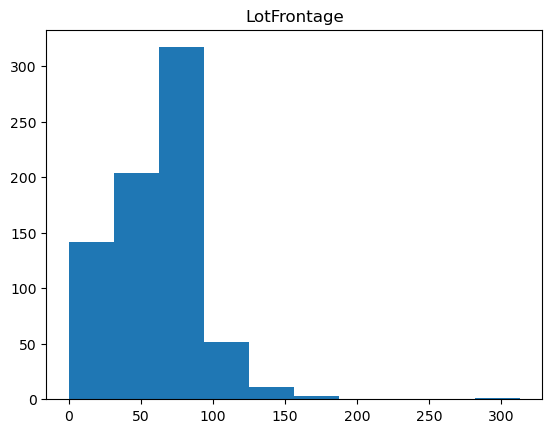

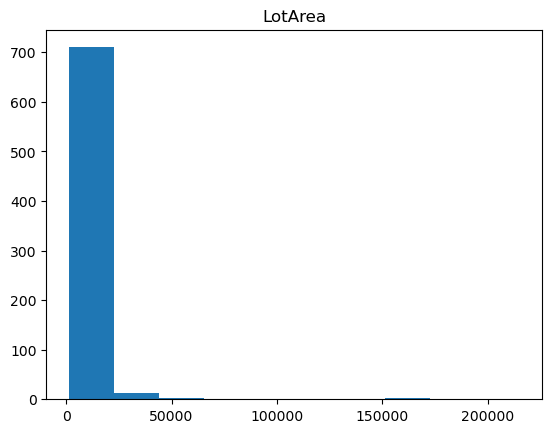

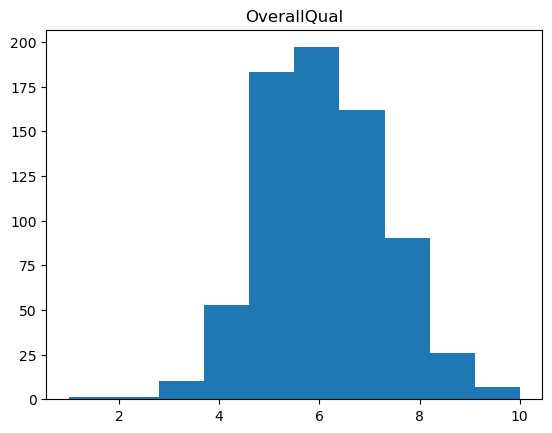

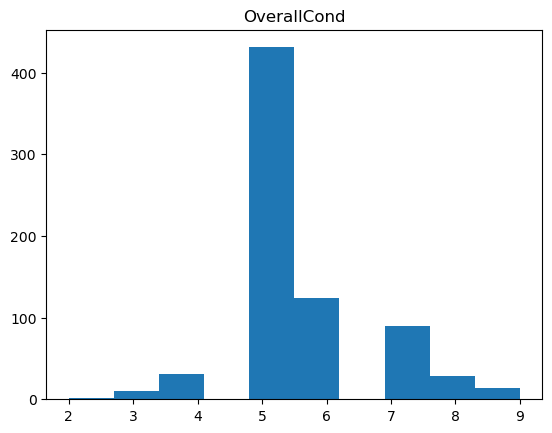

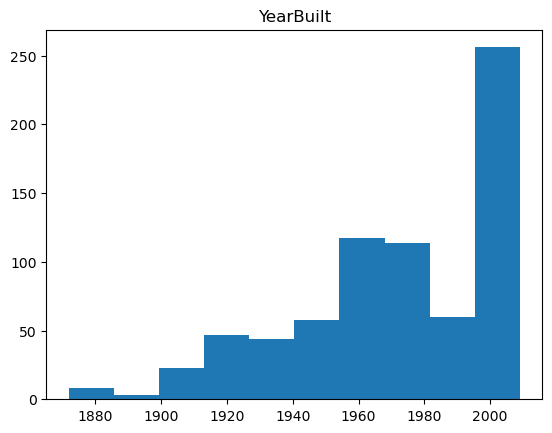

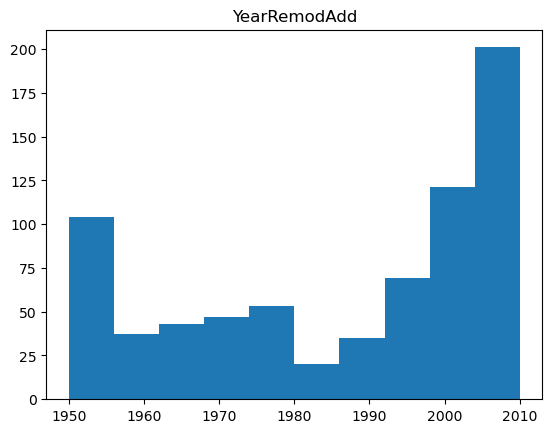

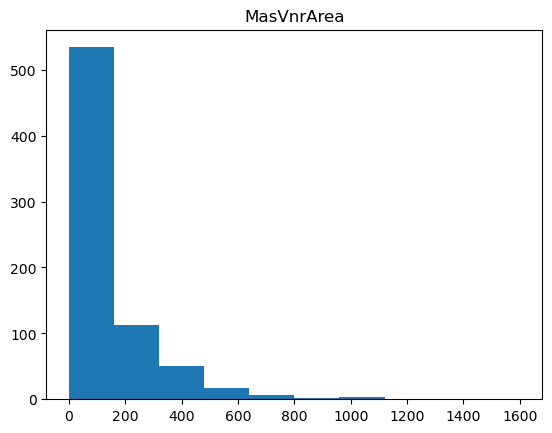

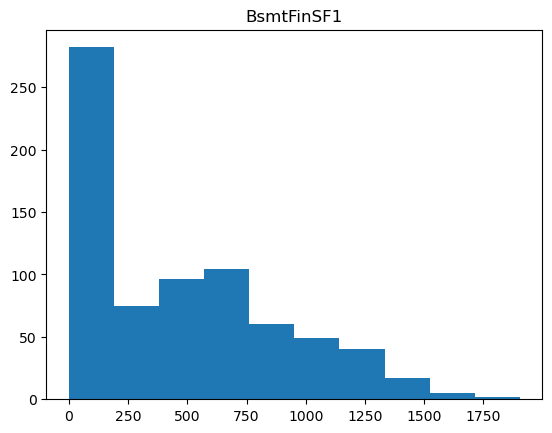

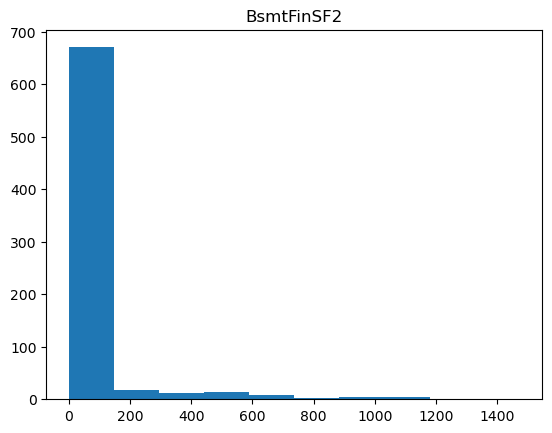

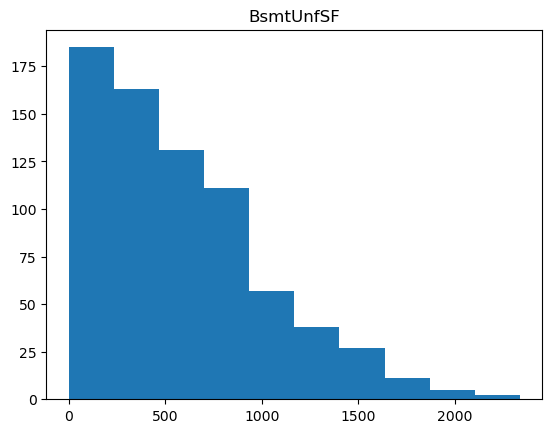

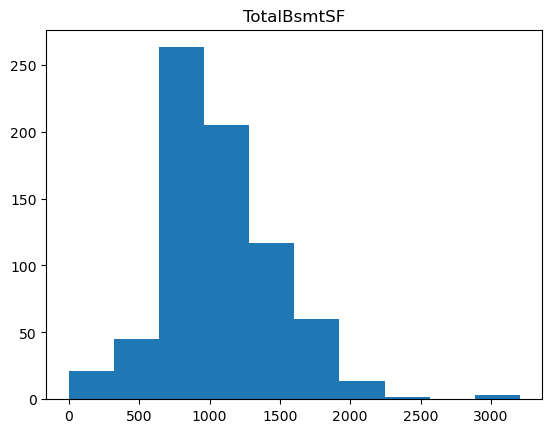

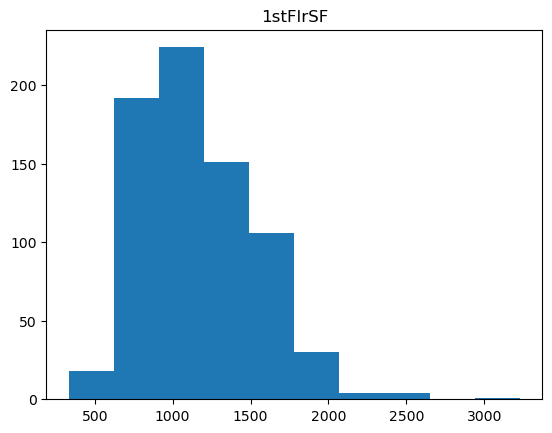

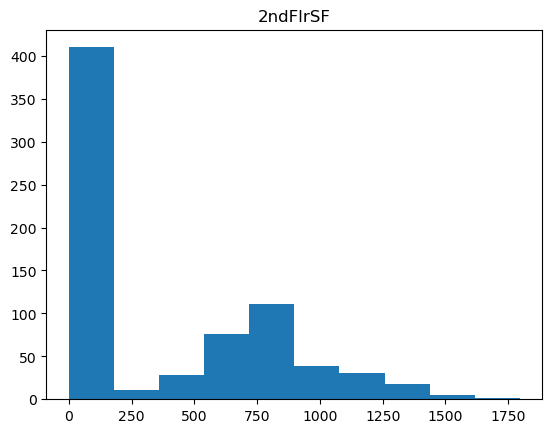

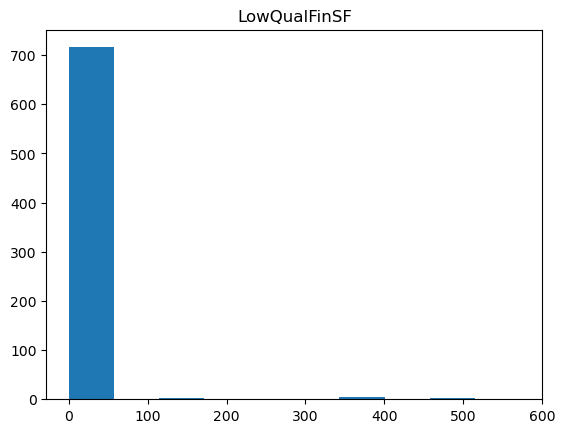

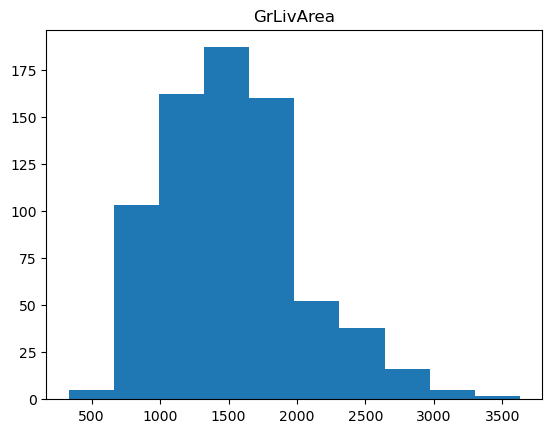

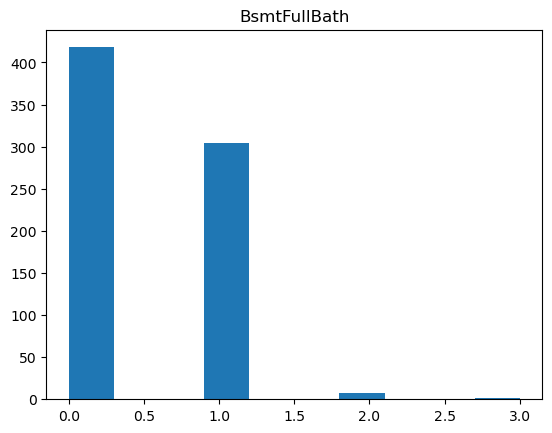

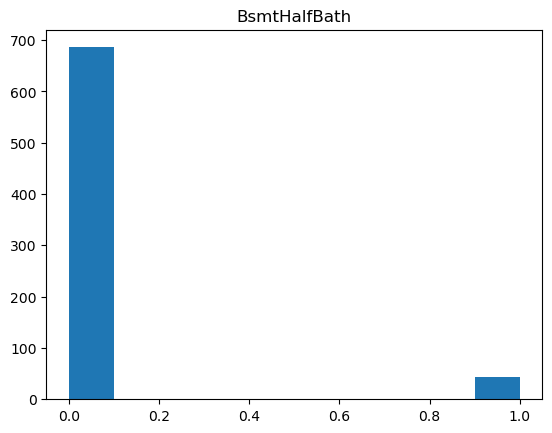

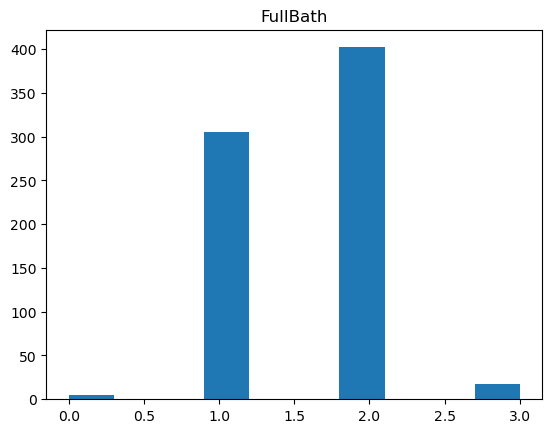

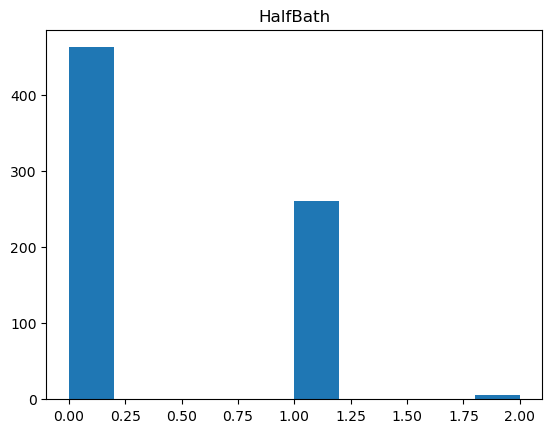

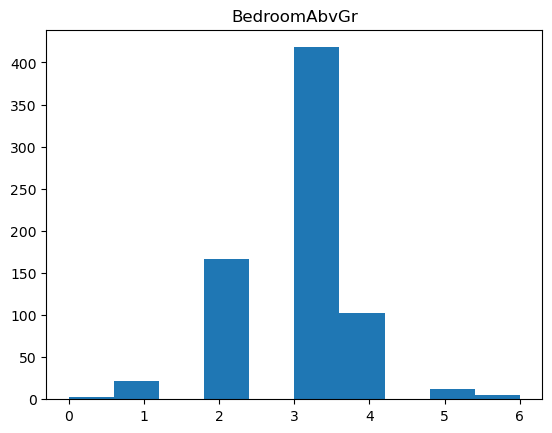

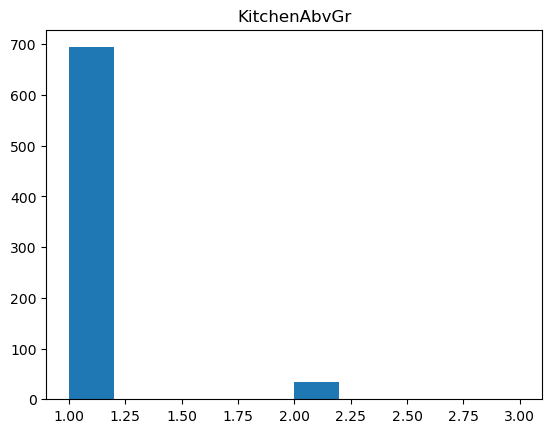

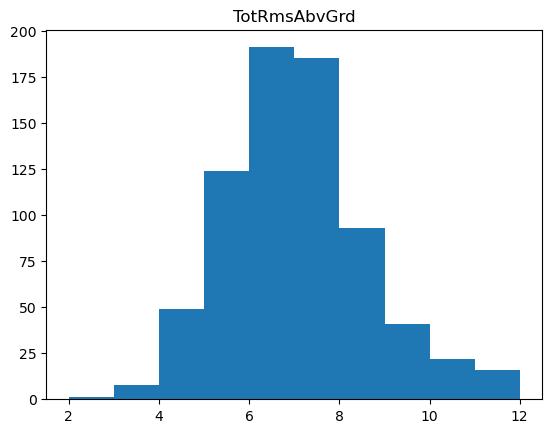

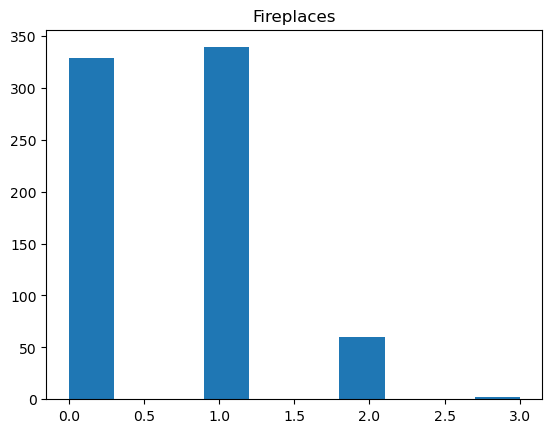

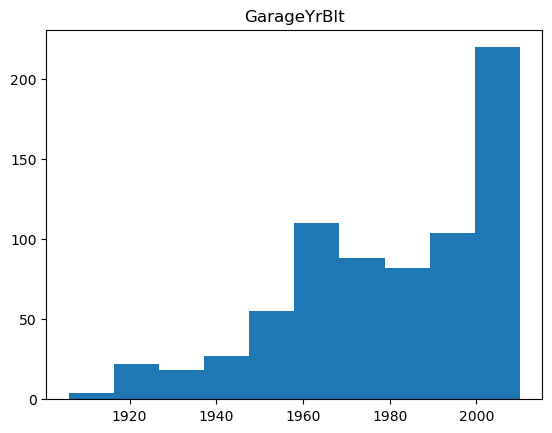

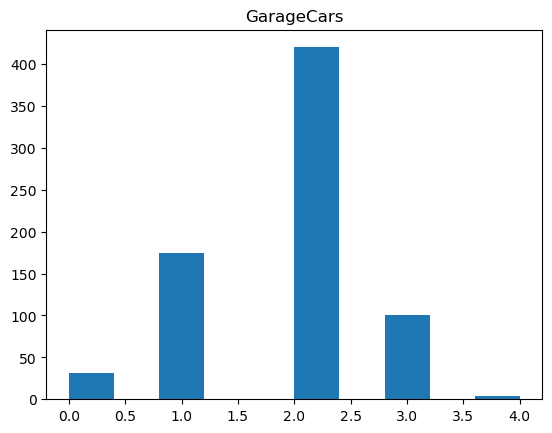

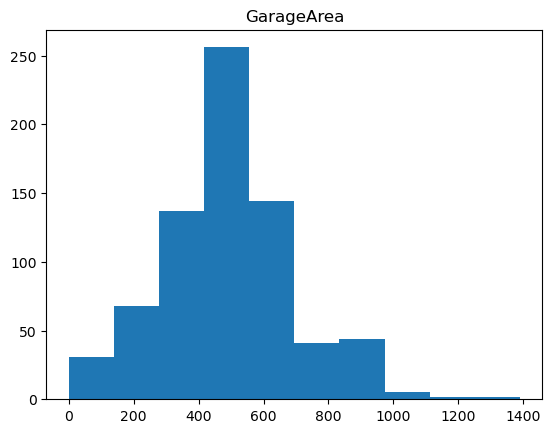

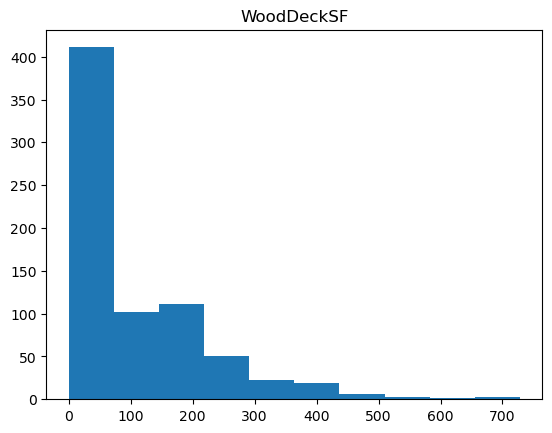

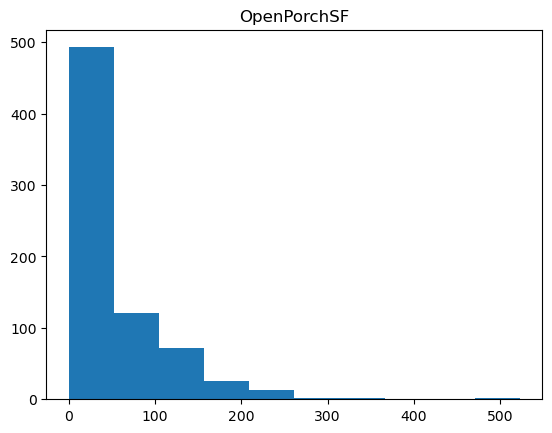

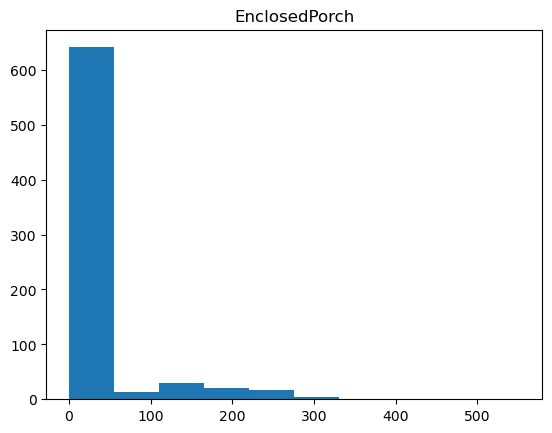

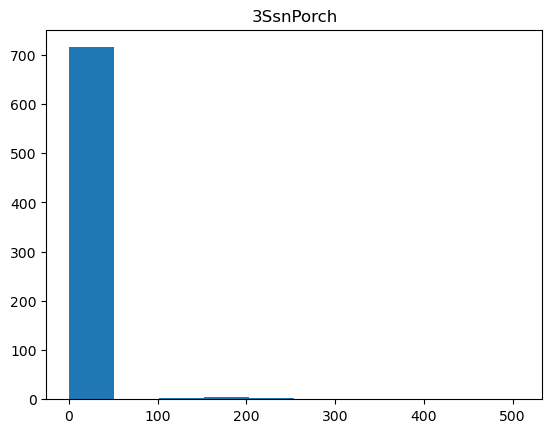

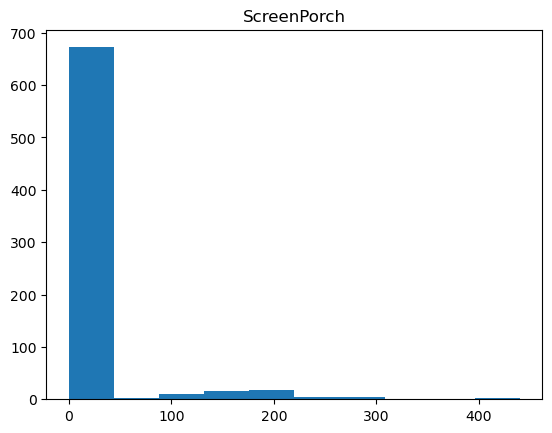

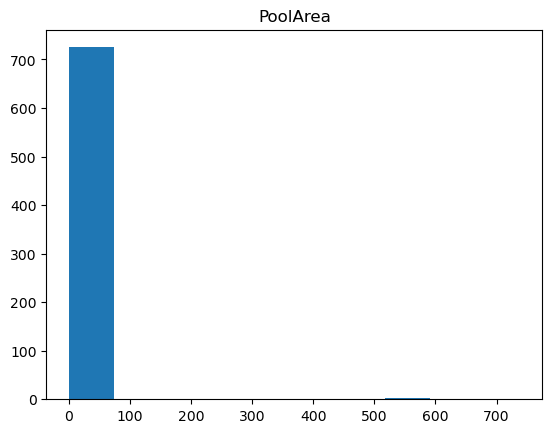

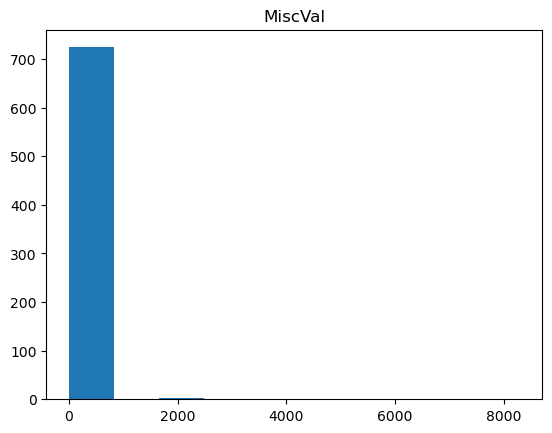

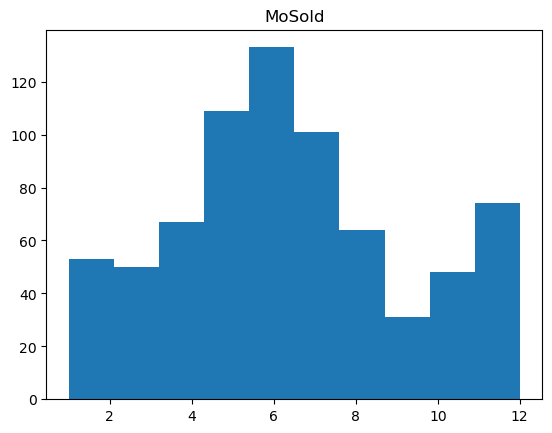

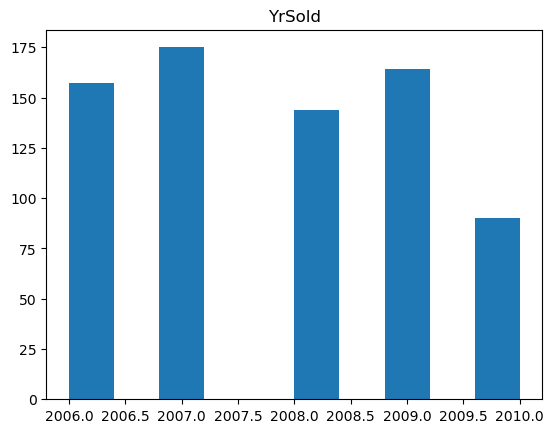

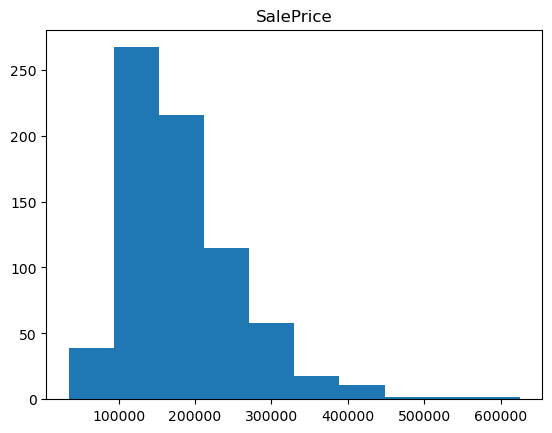

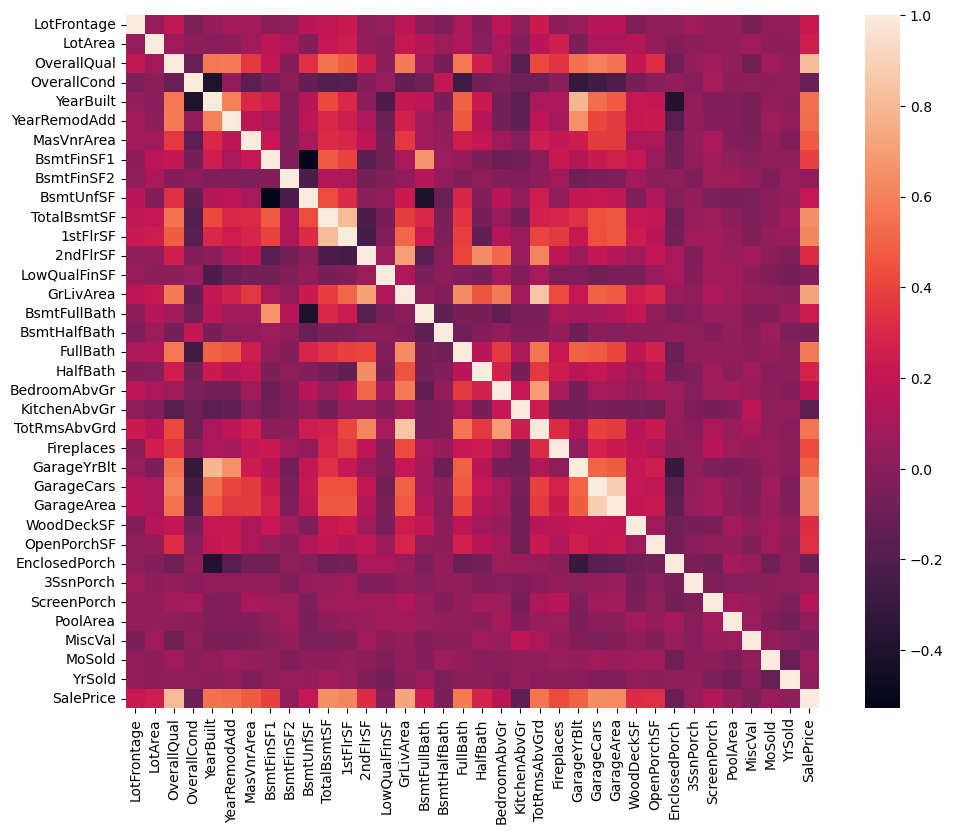

       LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count   730.000000     730.000000   730.000000   730.000000   730.000000   
mean     58.991781   10849.220548     6.164384     5.538356  1972.465753   
std      34.451452   12657.729930     1.373007     1.071789    30.999041   
min       0.000000    1300.000000     1.000000     2.000000  1872.000000   
25%      47.000000    7560.000000     5.000000     5.000000  1954.250000   
50%      64.000000    9515.000000     6.000000     5.000000  1976.000000   
75%      79.000000   11569.500000     7.000000     6.000000  2002.000000   
max     313.000000  215245.000000    10.000000     9.000000  2009.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count    730.000000   730.000000   730.000000   730.000000   730.000000  ...   
mean    1985.490411   108.638356   449.226027    44.076712   575.002740  ...   
std       20.631207   187.696229   436.199596   164.898879   446.421701  ..

/Users/neal/opt/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


GRADIENT BOOSTING MODEL: 
Best parameters:  {'gbr__max_depth': 4, 'gbr__max_features': 9, 'gbr__min_samples_leaf': 2, 'pca__n_components': 14}
R2 with cross val 0.7277319375876612
Accuracy after running model on test set:  0.6473382738656392


In [998]:
# the kaggle dataset testing data does not have labels
# so we split the train into train and test:
all_data = pd.read_csv("train.csv")
training, testing = train_test_split(all_data, test_size=0.50, random_state=11)
training_labels = training['SalePrice']
testing_labels = testing['SalePrice']

# 1. Clean Data
training = clean_data(training)
testing = clean_data(testing)

#2. Explore Data
explore_data(training)
print(training.describe())
print(testing.describe())

# call one square chi test function:
one_square_chi(training)


# one hot encode and do an inner join to make sure we have the same shape in test and train
ohe_train = one_hot_encode(training)
ohe_test = one_hot_encode(testing)
final_train, final_test = ohe_train.align(ohe_test, join='inner', axis=1)


# 3. Normalization
train_norm, test_norm = normalize_data(final_train, final_test)


# outlier detection:
run_isolation_forest(train_norm)

# 4. Feature Engineering: 

train_norm['SalePrice'] = training_labels
test_norm['SalePrice'] = testing_labels

# perform correlation between all feats. and SalePrice
corr_salePrice(train_norm)

train_collinear = multi_collinear_removal(train_norm)
test_collinear = multi_collinear_removal(test_norm)


# 5. Run Models
do_gradient_boosting_regression(train_collinear, test_collinear)


## Part 6: Results and Conclusion: 



The R2 values we got from running the models on our training set ranged from around ≈.52 to ≈.80. The R2 values we got from our test set ranged from around ≈.48 to ≈.84. The model that performed the best consistently with and without feature engineering was gradient boost. R2 scores for gradient boosting on the test set ranged from ≈.64 to ≈.67. However, we did come across an accuracy of .84 and .79 for Decision Tree Regression. The best parameters on these two runs were very high compared to the parameters in our runs for all the other models. For example, the number of components for PCA was at 41 and max depth was set at 20. The reason why we didn’t use as high of numbers for all our other models was because it took upwards of an hour to train the models. Another interesting observation that we made was that increasing the number of components for PCA increased the accuracy drastically with linear regression. For example, our accuracy jumped up to .72 from .62 by increasing the components from 25 to 50. However, the jump in accuracy wasn’t as drastic for our other runs since we only marginally increased the number of components for our other runs. We originally thought that having values upwards of 30 for PCA components would’ve caused overfitting, but it’s likely that we misjudged the upper bound before we reached a point of overfitting. Additionally, running the models after we combined features didn’t improve our accuracy. It seems like PCA did most of the heavy lifting in finding the most variance in the data since we had 236 features. We don’t believe that our feature engineering was bad since we combined features that were noticeably redundant, but we do believe that having larger hyperparameters would’ve likely given us better results. 